In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import csv
import datetime
import pandas as pd

plt.rcParams.update({'figure.autolayout': True})
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"

SMALL_SIZE = 10
MEDIUM_SIZE = 10
BIGGER_SIZE = 20

# From what I saw, dpi had no affect on saved pdf

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams['axes.titleweight'] = 'bold' # font weight

## **Lowpass Example**
### Creating a Signal

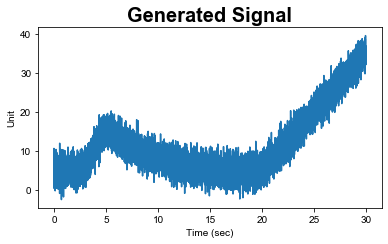

In [2]:
TIME = 30
FS = 300

def create_signal(domain, func):
    return domain, func(domain)

# Piecewise Function
x_1, gauss = create_signal(np.linspace(0,5.1,int(5.1*FS)), lambda x : (25/np.sqrt(2*np.pi))*(np.e**((-0.5)*(x-5)**2))+5)
x_2, exp_decline = create_signal(np.linspace(5.1,16.3,int(11.2*FS)), lambda x : 0.075*((x-16.6)**2)+5)
x_3, stable = create_signal(np.linspace(16.3,20,int(3.7*FS)), lambda x : x*0+5)
x_4, lin_rise = create_signal(np.linspace(20,30,int(10*FS)), lambda x : 3*x-60+5)

# Combine individual function domains adn their mappings
x_final = np.concatenate([x_1,x_2,x_3,x_4])
y_final = np.concatenate([gauss, exp_decline, stable, lin_rise])

# Noise #1: 20 Hz
# Noise #2: 40 Hz
# Noise #3: 80 Hz
# Noise #4: Random
x_noise, noise_1 = create_signal(x_final, lambda x : np.cos(2*np.pi*x*20))
x_noise, noise_2 = create_signal(x_final, lambda x : 2*np.sin(2*np.pi*x*40))
x_noise, noise_3 = create_signal(x_final, lambda x : np.sin(2*np.pi*x*80))
noise_4 = np.random.normal(0,1.5,len(x_final))

# Add noise
y_final += noise_1 + noise_2 + noise_3 + noise_4;

fig = plt.figure(figsize=(5.5,3.5))
plt.plot(x_final, y_final)
plt.tight_layout()
plt.title("Generated Signal")
plt.xlabel("Time (sec)")
plt.ylabel("Unit")
plt.savefig("img/Unfiltered.pdf",transparent=True)
plt.show()

### Filtering A Signal

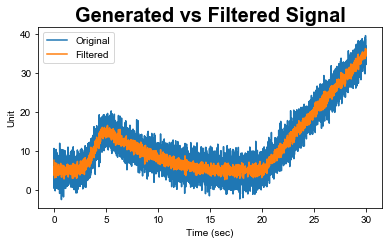

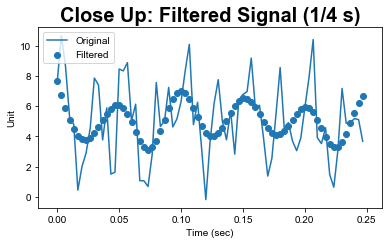

In [3]:
# Desired cutoff frequency (in Hz).
highcut = 25
w = highcut / (FS / 2)
b, a = sig.butter(5, w, "low")
filtered_signal = sig.filtfilt(b, a, y_final)

# 30 sec plot
plt.figure(figsize=(5.5,3.5))
plt.plot(x_final, y_final, label="Original")
plt.plot(x_final, filtered_signal, label="Filtered")
plt.title("Generated vs Filtered Signal")
plt.xlabel("Time (sec)")
plt.ylabel("Unit")
plt.legend(loc="upper left")
plt.savefig("img/Filter1.pdf",transparent=True)
plt.show()

# 1 sec plot
plt.figure(figsize=(5.5,3.5))
plt.plot(x_final[:FS//4], y_final[:FS//4], label="Original")
plt.scatter(x_final[:FS//4], filtered_signal[:FS//4], label="Filtered")
plt.title("Close Up: Filtered Signal (1/4 s)")
plt.xlabel("Time (sec)")
plt.ylabel("Unit")
plt.legend(loc="upper left")
plt.savefig("img/Filter2.pdf",transparent=True)
plt.show()

## **Smoothing: Rolling Mean and Savitzky-Golay Filter**

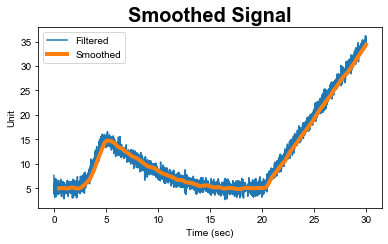

In [4]:
SMA_INIT = FS//2

# Converting to pnadas dataframe to moving mean functionality
data = {
    "sample": x_final,
    "y": filtered_signal
}
df = pd.DataFrame(data)
df["ExpMvAvg"] = df.iloc[:,1].ewm(span=FS//2, adjust=False).mean() # EMA
df["MvAvg"] = df.iloc[:,1].rolling(window=SMA_INIT).mean() # SMA
rolling_mean_ema = df["ExpMvAvg"]
rolling_mean_sma = df["MvAvg"]

# applying savgol
smoothed_signal = sig.savgol_filter(rolling_mean_sma[SMA_INIT:], 201, 2)
x_final_smoothed = x_final[SMA_INIT:]

plt.figure(figsize=(5.5,3.5))
plt.title("Smoothed Signal")
plt.plot(x_final, filtered_signal, label="Filtered")
plt.plot(x_final_smoothed, smoothed_signal, linewidth=4, label="Smoothed")
plt.xlabel("Time (sec)")
plt.ylabel("Unit")
plt.legend(loc="upper left")
plt.savefig("img/Filter3.pdf", transparent=True)
plt.show()

## **Identifying Changes**

### Finding The Derivative

In [5]:
def plot_der(der, name, x_vals=None):
    pos_x = []
    pos_y = []
    neg_x = []
    neg_y = []
    flt_x = []
    flt_y = []
    
    # Logic for two different methods
    if x_vals is None:
        for (i, n), t, y in zip(enumerate(der), x_final_smoothed, smoothed_signal):
            if n < -0.001:
                neg_x.append(t)
                neg_y.append(y)
            elif n > 0.001:
                pos_x.append(t)
                pos_y.append(y)
            else:
                flt_x.append(t)
                flt_y.append(y)
    else:
        for i, d in zip(x_vals, der):
            if d < -0.001:
                neg_x.append(x_final_smoothed[i])
                neg_y.append(smoothed_signal[i])
            elif d > 0.001:
                pos_x.append(x_final_smoothed[i])
                pos_y.append(smoothed_signal[i])
            else:
                flt_x.append(x_final_smoothed[i])
                flt_y.append(smoothed_signal[i])
     
    # Plotting
    plt.figure(figsize=(5.5,3.5))
    if x_vals is None:
        plt.title("Derivative: Every Sample")
    else:
        plt.title("Derivative: Every N Samples")
    plt.scatter(pos_x, pos_y, 10, label="Pos")
    plt.scatter(neg_x, neg_y, 10, label="Neg")
    plt.scatter(flt_x, flt_y, 10, label="Zero")
    plt.legend(loc="upper left")
    plt.xlabel("Time (sec)")
    plt.ylabel("Unit")
    plt.savefig(name,transparent=True)
    plt.show()

### Method One

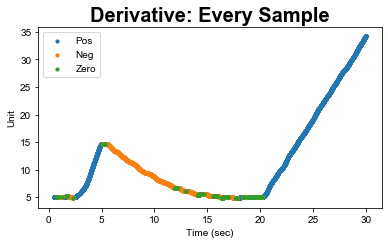

In [6]:
dx = TIME / FS
der = np.diff(smoothed_signal) / dx
plot_der(der, "img/Der1.pdf")

### Method Two

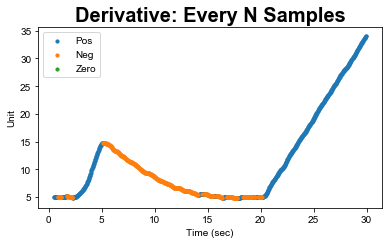

In [7]:
# Constraint on space: if space is too big in reltion to the number of samples in the dataset, 
# the performance of this method decreases and will outright fail if space is too big

x_vals = []
der = []
space = 10
for i in range(space, len(x_final_smoothed), space):
    x1 = x_final_smoothed[i-space]
    x2 = x_final_smoothed[i]
    y1 = smoothed_signal[i-space]
    y2 = smoothed_signal[i]
    der.append((y2-y1)/(x2-x1))
    x_vals.append(i-space)

plot_der(der,"img/Der2.pdf", x_vals)

## **Setting Limits**

In [8]:
MIN = 6
MAX = 20

def plot_limits(min_x, min_y, max_x, max_y):
    
    # Dashed lines range
    lower_bound = [MIN]*(FS*TIME)
    upper_bound = [MAX]*(FS*TIME)
            
    plt.figure(figsize=(5.5,3.5))
    plt.title("Threshold Classification")

    
    # Dashed lines plot
    plt.plot(x_final, lower_bound, "r--")
    plt.plot(x_final, upper_bound, "r--")
    
    # Data Points (in bounds)
    plt.plot(x_final_smoothed, smoothed_signal)
    
    # Lower Limit
    plt.scatter(min_x, min_y, label="Below Min (5)")
    
    # Upper Limit
    plt.scatter(max_x, max_y, label="Above Max (20)")
    
    plt.legend(loc="upper left")
    plt.xlabel("Time (sec)")
    plt.ylabel("Unit")
    plt.savefig("img/Threshold.pdf",transparent=True)
    plt.show()
    

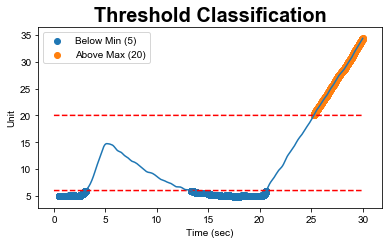

In [9]:
min_x = []
min_y = []
max_x = []
max_y = []

for x, y in zip(x_final_smoothed, smoothed_signal):
    if y < MIN:
        min_x.append(x)
        min_y.append(y)
    elif y > MAX:
        max_x.append(x)
        max_y.append(y)

plot_limits(min_x, min_y, max_x, max_y)

## **Incremental Saving**
What: Record the data (sample number, temperature) for a sample every "n" samples.
Why: Allows us to monitor the state of the sensor over time. 

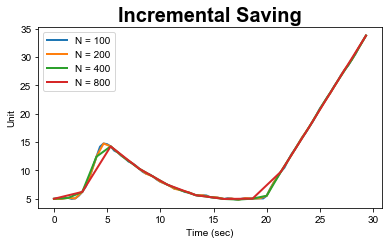

In [21]:
# We take 1 sample every "space" samples
space = [100,200,400,800]

def write_data(filename, n):
    with open(filename, "w", newline='') as csvfile: # this is write mode for now, we would use append mode if we were doing real-time
        fieldnames = ["unit", "time", "sample_number", "data"] # we would also do away with sample_number and just keep timestamp if real-time
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for i in range(len(x_final_smoothed)):
            if i % n == 0:
                writer.writerow({"unit": "temp", "time": x_final_smoothed[i], "sample_number": i, "data": format(smoothed_signal[i], ".2f")})

def plot_saved_data(filename, n):
    saved_time = []
    saved_data = []
    with open(filename, "r", newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        saved_time = []
        saved_data = []
        for row in reader:
            saved_time.append(int(row["sample_number"]))
            saved_data.append(float(row["data"]))
    
    saved_time = np.asarray(saved_time)
            
    plt.title("Incremental Saving")
    plt.xlabel("Time (sec)")
    plt.ylabel("Unit")
    plt.plot(saved_time/FS, saved_data, label="N = " + str(n), linewidth=2)
    
plt.figure(figsize=(5.5,3.5))
for n in space:    
    write_data("csv/saved" + str(n) + ".csv", n)
    plot_saved_data("csv/saved" + str(n) + ".csv", n)
plt.legend(loc="upper left")
plt.savefig("img/IncrSaving.pdf", transparent=True)
plt.show()